In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as warn
warn.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Importing and Saving the BTC-USD historical price data from Yahoo Finance

In [3]:
btc_cc = yf.download("BTC-USD", start="2014-09-17", end="2025-03-31", auto_adjust=False)
btc_cc

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...,...
2025-03-26,86900.882812,86900.882812,88292.156250,85861.453125,87460.234375,26704046038
2025-03-27,87177.101562,87177.101562,87786.726562,85837.937500,86896.257812,24413471941


In [4]:
# Cleaning the multi-level column names
btc_cc.reset_index(inplace=True)
btc_cc.columns = ['_'.join(filter(None, column_name)).strip() if isinstance(column_name, tuple) else column_name for column_name in btc_cc.columns]
btc_cc.columns = [column_name.replace('_BTC-USD', '') for column_name in btc_cc.columns]
btc_cc

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...,...,...
3843,2025-03-26,86900.882812,86900.882812,88292.156250,85861.453125,87460.234375,26704046038
3844,2025-03-27,87177.101562,87177.101562,87786.726562,85837.937500,86896.257812,24413471941
3845,2025-03-28,84353.148438,84353.148438,87489.859375,83557.640625,87185.234375,34198619509
3846,2025-03-29,82597.585938,82597.585938,84567.335938,81634.140625,84352.070312,16969396135


In [6]:
btc_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3848 non-null   datetime64[ns]
 1   Adj Close  3848 non-null   float64       
 2   Close      3848 non-null   float64       
 3   High       3848 non-null   float64       
 4   Low        3848 non-null   float64       
 5   Open       3848 non-null   float64       
 6   Volume     3848 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 210.6 KB


Viewing the Start and End Dates in this imported BTC historical crypto trading data

In [7]:
first_date = btc_cc['Date'].min()
last_date = btc_cc['Date'].max()

print("First trading date in this BTC historical data:", first_date.date())
print("Last trading date in this BTC historical data:", last_date.date())

First trading date in this BTC historical data: 2014-09-17
Last trading date in this BTC historical data: 2025-03-30


In [15]:
btc_cc = btc_cc[['Date', 'Close']]
btc_cc.to_csv('btc_usd(date&Close).csv', index=False)
btc_cc

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3843,2025-03-26,86900.882812
3844,2025-03-27,87177.101562
3845,2025-03-28,84353.148438
3846,2025-03-29,82597.585938


# **Sliding window one-step ahead forecasting**

In [16]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for LSTM: {X.shape}")

Input shape (X): (3838, 10)
Target shape (y): (3838,)
Example input: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511 423.20498657 411.57400513 404.42498779]
Expected output: 399.5199890136719
Reshaped input for LSTM: (3838, 10, 1)


**DAta Splitting into Training and Testing**

In [17]:
#Define split dates
val_start_date = np.datetime64('2024-10-01')
test_start_date = np.datetime64('2025-01-01')

# Create masks for each period
train_mask = y_dates < val_start_date
val_mask = (y_dates >= val_start_date) & (y_dates < test_start_date)
test_mask = y_dates >= test_start_date

# Split the data
X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]

# Print shapes
print(f"\nTraining set:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Validation set:  X = {X_val.shape},    y = {y_val.shape}")
print(f"Testing set:     X = {X_test.shape},   y = {y_test.shape}")


Training set:    X = (3657, 10, 1),  y = (3657,)
Validation set:  X = (92, 10, 1),    y = (92,)
Testing set:     X = (89, 10, 1),   y = (89,)


**Scaling the Data using Robust Scaler**

In [18]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

x_scaler = RobustScaler()
X_train_scaled = x_scaler.fit_transform(X_train_reshaped)
X_val_scaled = x_scaler.transform(X_val_reshaped)
X_test_scaled = x_scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [19]:
X_train_scaled

array([[[-0.31046251],
        [-0.31163273],
        [-0.31268733],
        ...,
        [-0.31167666],
        [-0.31209044],
        [-0.31234477]],

       [[-0.31163273],
        [-0.31268733],
        [-0.31218543],
        ...,
        [-0.31209044],
        [-0.31234477],
        [-0.31251927]],

       [[-0.31268733],
        [-0.31218543],
        [-0.31254414],
        ...,
        [-0.31234477],
        [-0.31251927],
        [-0.31331399]],

       ...,

       [[ 1.86648567],
        [ 1.91240572],
        [ 1.92138922],
        ...,
        [ 1.91961642],
        [ 1.99211484],
        [ 2.01380325]],

       [[ 1.91240572],
        [ 1.92138922],
        [ 1.92857061],
        ...,
        [ 1.99211484],
        [ 2.01380325],
        [ 2.01725352]],

       [[ 1.92138922],
        [ 1.92857061],
        [ 1.9376022 ],
        ...,
        [ 2.01380325],
        [ 2.01725352],
        [ 2.00827626]]])

In [20]:
X_val_scaled

array([[[1.92857061],
        [1.9376022 ],
        [1.92625681],
        [1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611]],

       [[1.9376022 ],
        [1.92625681],
        [1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611],
        [1.83757446]],

       [[1.92625681],
        [1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611],
        [1.83757446],
        [1.83030914]],

       [[1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611],
        [1.83757446],
        [1.83030914],
        [1.83481361]],

       [[1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
  

In [21]:
y_test_scaled

array([3.02455875, 3.11212517, 3.15544682, 3.16001827, 3.16281282,
       3.29637899, 3.11339683, 3.04669832, 2.95585347, 3.03455708,
       3.02977046, 3.02699642, 3.02799329, 3.09960209, 3.24052677,
       3.21399239, 3.38099363, 3.3790781 , 3.26129457, 3.29419891,
       3.44077259, 3.35228056, 3.36318065, 3.39368059, 3.3899596 ,
       3.31783171, 3.29671978, 3.26991476, 3.35406023, 3.39069276,
       3.30798312, 3.24590097, 3.14059449, 3.27250384, 3.14708424,
       3.1024912 , 3.10170508, 3.09942601, 3.09777085, 3.09839698,
       3.13167067, 3.07168236, 3.14758254, 3.10279012, 3.1342054 ,
       3.13673902, 3.0868594 , 3.07260352, 3.06430389, 3.10320689,
       3.16348636, 3.08510303, 3.10115354, 3.09036937, 2.9180222 ,
       2.82282886, 2.66704298, 2.67972134, 2.66796525, 2.7268455 ,
       3.01847495, 2.72804368, 2.76909265, 2.8898188 , 2.86632798,
       2.75207273, 2.73119982, 2.53408519, 2.46064792, 2.6143419 ,
       2.64487151, 2.5506132 , 2.65362924, 2.66690405, 2.60431

# **Unidirectional LSTM**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - loss: 0.0470 - mae: 0.0925 - val_loss: 0.0198 - val_mae: 0.1131
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0036 - mae: 0.0348 - val_loss: 0.0291 - val_mae: 0.1316
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.0029 - mae: 0.0293 - val_loss: 0.0214 - val_mae: 0.1128
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0023 - mae: 0.0268 - val_loss: 0.0286 - val_mae: 0.1383
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0020 - mae: 0.0245 - val_loss: 0.0134 - val_mae: 0.0901
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0019 - mae: 0.0246 - val_loss: 0.0114 - val_mae: 0.0832
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0018 - mae: 0.0220 - val_loss: 0.0282 - val_mae: 0.1426
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0019 - mae: 0.0240 - val_loss: 0.0109 - val_mae: 0.0804
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms

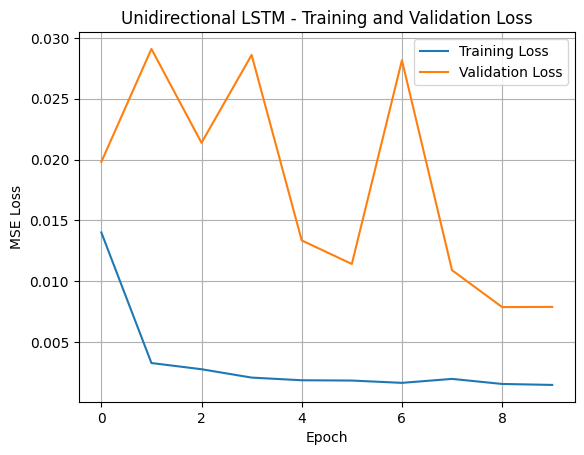

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

 Metrics - Uni-LSTM: Validation Set
MAE  - 1937.4141
MSE  - 6261637.5956
RMSE - 2502.3264
R²   - 0.9725
MAPE - 2.34%

 Metrics - Uni-LSTM: Test Set
MAE  - 2148.6257
MSE  - 7563031.5530
RMSE - 2750.0966
R²   - 0.8596
MAPE - 2.35%


In [22]:
# Building Uni-directional LSTM model for next-day price prediction
Uni_LSTM = Sequential()
Uni_LSTM.add(LSTM(300, activation='selu', input_shape=(window_size, 1)))
Uni_LSTM.add(Dense(1))
Uni_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Uni-LSTM model
history_uni_lstm = Uni_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_uni_lstm.history['loss'], label='Training Loss')
plt.plot(history_uni_lstm.history['val_loss'], label='Validation Loss')
plt.title('Unidirectional LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = Uni_LSTM.predict(X_val_scaled).flatten()
y_test_pred_scaled = Uni_LSTM.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics - Uni-LSTM: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics - Uni-LSTM: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Some test predictions of Unidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 94137.4140625

Sample 2
Last 10 days input (closing btc price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 94973.984375

Sample 3
Last 10 days input (closing btc price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 96890.9921875

Sample 4
Last 10 days input (closing btc price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closing price      : 982

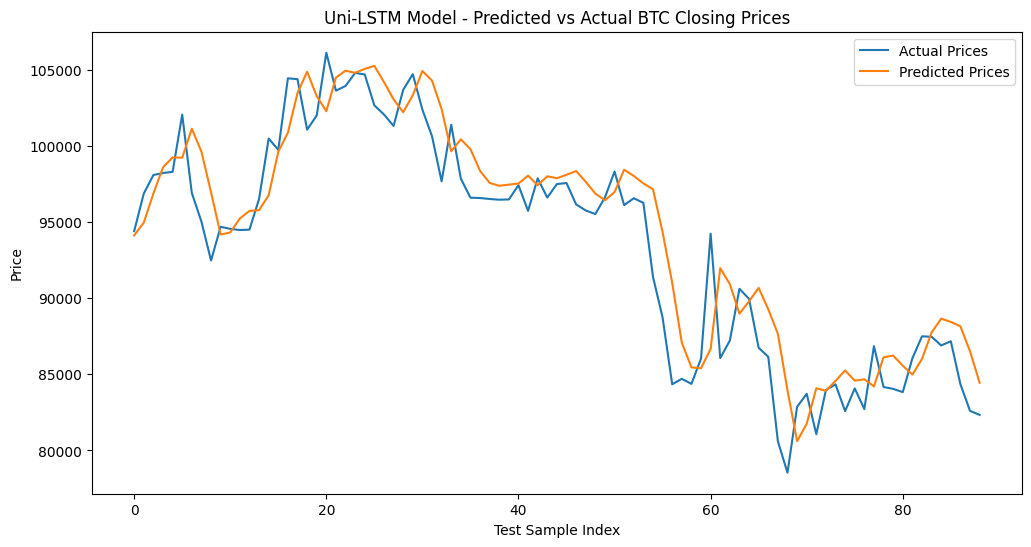

In [23]:
print("\nSome test predictions of Unidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Uni-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Bidirectional LSTM**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - loss: 0.0328 - mae: 0.0904 - val_loss: 0.0441 - val_mae: 0.1670
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0027 - mae: 0.0294 - val_loss: 0.0444 - val_mae: 0.1787
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0029 - mae: 0.0310 - val_loss: 0.0643 - val_mae: 0.2252
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0022 - mae: 0.0265 - val_loss: 0.0175 - val_mae: 0.1052
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0021 - mae: 0.0258 - val_loss: 0.0317 - val_mae: 0.1464
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.0019 - mae: 0.0251 - val_loss: 0.0279 - val_mae: 0.1341
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0017 - mae: 0.0231 - val_loss: 0.0135 - val_mae: 0.0916
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0015 - mae: 0.0216 - val_loss: 0.0170 - val_mae: 0.1025
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 79

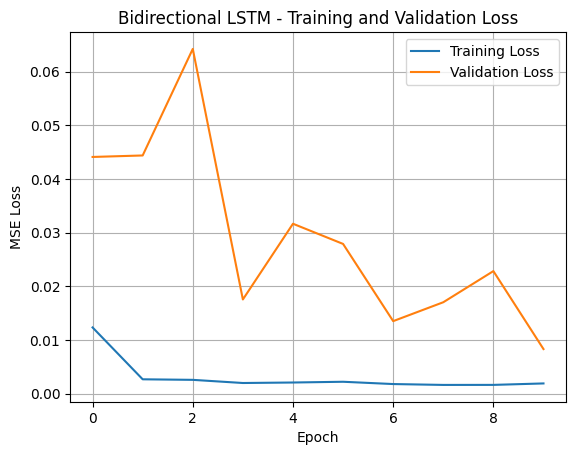

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

 Metrics - Bi-LSTM: Validation Set
MAE  - 2075.1756
MSE  - 6587860.5597
RMSE - 2566.6828
R²   - 0.9711
MAPE - 2.56%

 Metrics - Bi-LSTM: Test Set
MAE  - 1979.6716
MSE  - 6764419.8308
RMSE - 2600.8498
R²   - 0.8745
MAPE - 2.16%


In [24]:
# Building Bi-directional LSTM model for next-day price prediction
Bi_LSTM = Sequential()
Bi_LSTM.add(Bidirectional(LSTM(300, activation='selu', input_shape=(window_size, 1))))
Bi_LSTM.add(Dense(1))
Bi_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Bi-LSTM model
history_bi_lstm = Bi_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_bi_lstm.history['loss'], label='Training Loss')
plt.plot(history_bi_lstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = Bi_LSTM.predict(X_val_scaled).flatten()
y_test_pred_scaled = Bi_LSTM.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics - Bi-LSTM: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics - Bi-LSTM: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Some test predictions of Bidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93403.625

Sample 2
Last 10 days input (closing btc price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 94196.453125

Sample 3
Last 10 days input (closing btc price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 95977.90625

Sample 4
Last 10 days input (closing btc price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closing price      : 98236.2265

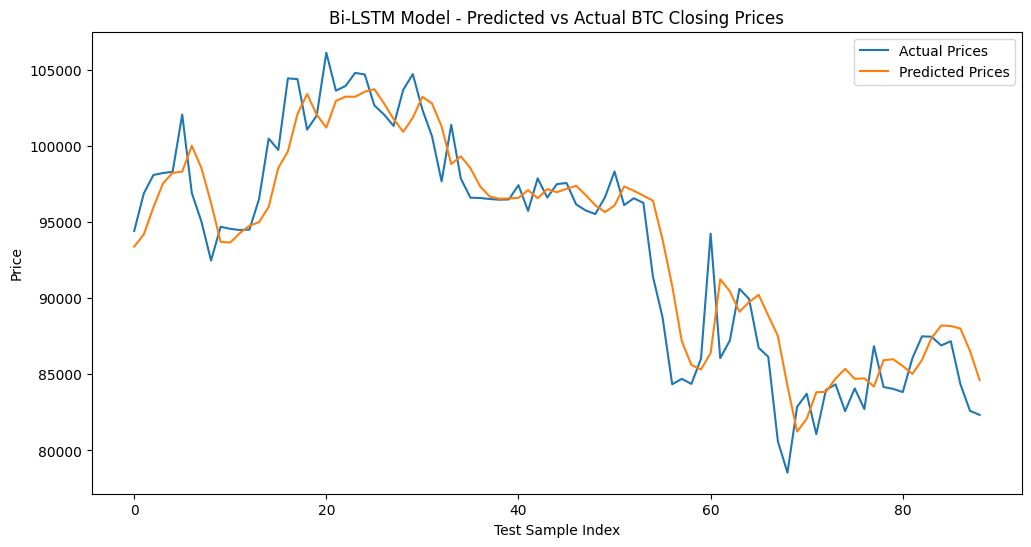

In [25]:
print("\nSome test predictions of Bidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Bi-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Stacked LSTM**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0440 - mae: 0.0993 - val_loss: 0.1350 - val_mae: 0.3269
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0044 - mae: 0.0363 - val_loss: 0.0190 - val_mae: 0.1069
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 0.0025 - mae: 0.0280 - val_loss: 0.0320 - val_mae: 0.1427
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0033 - mae: 0.0328 - val_loss: 0.0215 - val_mae: 0.1147
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.0020 - mae: 0.0240 - val_loss: 0.0103 - val_mae: 0.0785
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0016 - mae: 0.0224 - val_loss: 0.0098 - val_mae: 0.0800
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0017 - mae: 0.0230 - val_loss: 0.0189 - val_mae: 0.1093
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0015 - mae: 0.0215 - val_loss: 0.0073 - val_mae: 0.0665
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 7

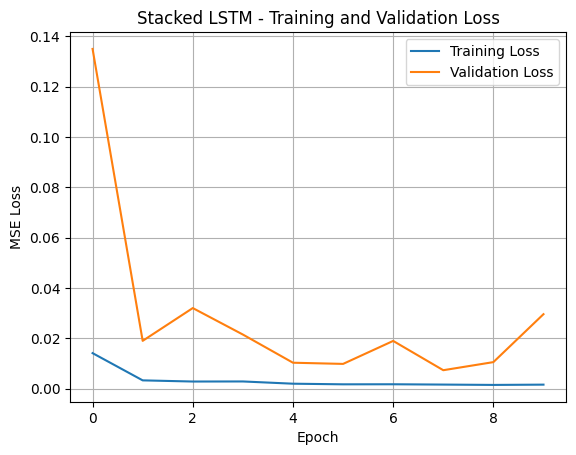

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

 Metrics - Stacked LSTM: Validation Set
MAE  - 2075.1756
MSE  - 6587860.5597
RMSE - 2566.6828
R²   - 0.9711
MAPE - 2.56%

 Metrics - Stacked LSTM: Test Set
MAE  - 1979.6716
MSE  - 6764419.8308
RMSE - 2600.8498
R²   - 0.8745
MAPE - 2.16%


In [26]:
# Building Stacked LSTM model for next-day price prediction
stacked_LSTM = Sequential()
stacked_LSTM.add(LSTM(300, activation='selu', return_sequences=True, input_shape=(window_size, 1)))
stacked_LSTM.add(LSTM(150, activation='selu'))
stacked_LSTM.add(Dense(1))
stacked_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Stacked LSTM model
history_stacked_lstm = stacked_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_stacked_lstm.history['loss'], label='Training Loss')
plt.plot(history_stacked_lstm.history['val_loss'], label='Validation Loss')
plt.title('Stacked LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = Bi_LSTM.predict(X_val_scaled).flatten()
y_test_pred_scaled = Bi_LSTM.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics - Stacked LSTM: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics - Stacked LSTM: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Checking some test predictions - Stacked LSTM

Sample 1
Last 10 days input (closing price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93403.625

Sample 2
Last 10 days input (closing price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 94196.453125

Sample 3
Last 10 days input (closing price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 95977.90625

Sample 4
Last 10 days input (closing price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closing price      : 98236.2265625
Predicted

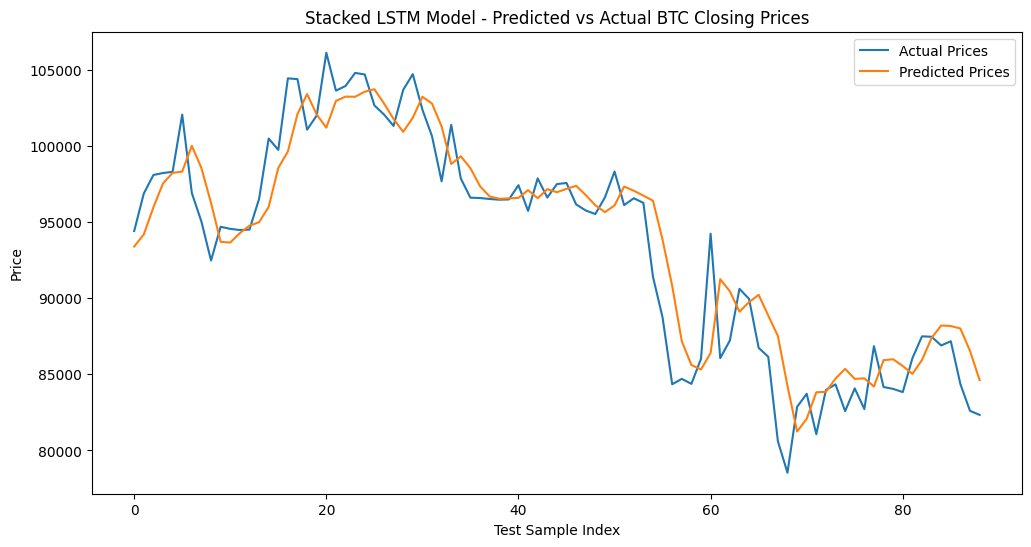

In [27]:
print("\nChecking some test predictions - Stacked LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Stacked LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()